<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/gru_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\camjt\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.9.1


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [5]:
def get_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series


In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [7]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

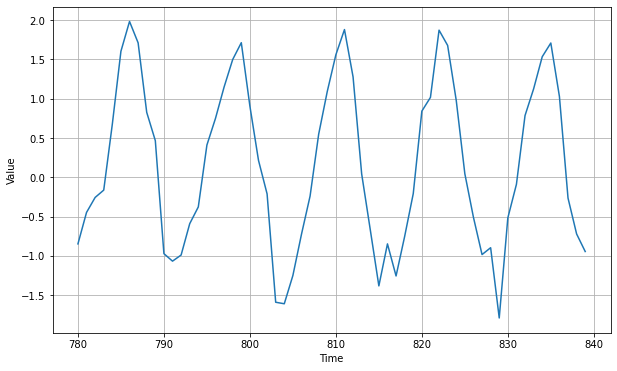

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.GRU(100), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=1000,  verbose=1, validation_data=valid_dataset)

Epoch 1/1000


C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


38/38 [==============================] - 5s 48ms/step - loss: 0.4597 - mae: 0.8721 - val_loss: 0.5260 - val_mae: 0.9445
Epoch 2/1000
38/38 [==============================] - 1s 20ms/step - loss: 0.4582 - mae: 0.8702 - val_loss: 0.5245 - val_mae: 0.9425
Epoch 3/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.4567 - mae: 0.8684 - val_loss: 0.5230 - val_mae: 0.9405
Epoch 4/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.4551 - mae: 0.8666 - val_loss: 0.5215 - val_mae: 0.9384
Epoch 5/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.4537 - mae: 0.8648 - val_loss: 0.5200 - val_mae: 0.9364
Epoch 6/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.4522 - mae: 0.8630 - val_loss: 0.5185 - val_mae: 0.9344
Epoch 7/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.4507 - mae: 0.8612 - val_loss: 0.5170 - val_mae: 0.9324
Epoch 8/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.4492 

38/38 [==============================] - 1s 17ms/step - loss: 0.3754 - mae: 0.7708 - val_loss: 0.4348 - val_mae: 0.8288
Epoch 63/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.3740 - mae: 0.7691 - val_loss: 0.4331 - val_mae: 0.8269
Epoch 64/1000
38/38 [==============================] - 1s 19ms/step - loss: 0.3725 - mae: 0.7674 - val_loss: 0.4315 - val_mae: 0.8250
Epoch 65/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.3711 - mae: 0.7656 - val_loss: 0.4299 - val_mae: 0.8231
Epoch 66/1000
38/38 [==============================] - 1s 20ms/step - loss: 0.3696 - mae: 0.7639 - val_loss: 0.4282 - val_mae: 0.8212
Epoch 67/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.3682 - mae: 0.7621 - val_loss: 0.4266 - val_mae: 0.8194
Epoch 68/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.3667 - mae: 0.7604 - val_loss: 0.4249 - val_mae: 0.8175
Epoch 69/1000
38/38 [==============================] - 1s 18ms/step - loss: 

38/38 [==============================] - 1s 24ms/step - loss: 0.2719 - mae: 0.6406 - val_loss: 0.3154 - val_mae: 0.6838
Epoch 124/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.2699 - mae: 0.6379 - val_loss: 0.3130 - val_mae: 0.6807
Epoch 125/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.2678 - mae: 0.6352 - val_loss: 0.3107 - val_mae: 0.6775
Epoch 126/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.2658 - mae: 0.6324 - val_loss: 0.3083 - val_mae: 0.6743
Epoch 127/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.2637 - mae: 0.6297 - val_loss: 0.3059 - val_mae: 0.6711
Epoch 128/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.2617 - mae: 0.6269 - val_loss: 0.3035 - val_mae: 0.6679
Epoch 129/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.2596 - mae: 0.6241 - val_loss: 0.3011 - val_mae: 0.6646
Epoch 130/1000
38/38 [==============================] - 1s 18ms/step -

Epoch 184/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.1441 - mae: 0.4465 - val_loss: 0.1651 - val_mae: 0.4695
Epoch 185/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.1423 - mae: 0.4432 - val_loss: 0.1629 - val_mae: 0.4660
Epoch 186/1000
38/38 [==============================] - 1s 19ms/step - loss: 0.1405 - mae: 0.4399 - val_loss: 0.1607 - val_mae: 0.4627
Epoch 187/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.1386 - mae: 0.4367 - val_loss: 0.1586 - val_mae: 0.4596
Epoch 188/1000
38/38 [==============================] - 1s 13ms/step - loss: 0.1368 - mae: 0.4334 - val_loss: 0.1565 - val_mae: 0.4565
Epoch 189/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.1351 - mae: 0.4302 - val_loss: 0.1545 - val_mae: 0.4534
Epoch 190/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.1333 - mae: 0.4270 - val_loss: 0.1524 - val_mae: 0.4503
Epoch 191/1000
38/38 [==============================] -

Epoch 245/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0748 - mae: 0.3096 - val_loss: 0.0854 - val_mae: 0.3440
Epoch 246/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0744 - mae: 0.3085 - val_loss: 0.0850 - val_mae: 0.3432
Epoch 247/1000
38/38 [==============================] - 1s 13ms/step - loss: 0.0739 - mae: 0.3075 - val_loss: 0.0845 - val_mae: 0.3424
Epoch 248/1000
38/38 [==============================] - 1s 13ms/step - loss: 0.0735 - mae: 0.3066 - val_loss: 0.0840 - val_mae: 0.3416
Epoch 249/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0731 - mae: 0.3056 - val_loss: 0.0836 - val_mae: 0.3409
Epoch 250/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0727 - mae: 0.3047 - val_loss: 0.0832 - val_mae: 0.3401
Epoch 251/1000
38/38 [==============================] - 1s 13ms/step - loss: 0.0724 - mae: 0.3038 - val_loss: 0.0828 - val_mae: 0.3395
Epoch 252/1000
38/38 [==============================] -

Epoch 306/1000
38/38 [==============================] - 1s 13ms/step - loss: 0.0636 - mae: 0.2832 - val_loss: 0.0739 - val_mae: 0.3220
Epoch 307/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0635 - mae: 0.2831 - val_loss: 0.0739 - val_mae: 0.3220
Epoch 308/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0635 - mae: 0.2830 - val_loss: 0.0738 - val_mae: 0.3218
Epoch 309/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0635 - mae: 0.2829 - val_loss: 0.0738 - val_mae: 0.3218
Epoch 310/1000
38/38 [==============================] - 1s 13ms/step - loss: 0.0634 - mae: 0.2828 - val_loss: 0.0738 - val_mae: 0.3217
Epoch 311/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0634 - mae: 0.2827 - val_loss: 0.0737 - val_mae: 0.3216
Epoch 312/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0633 - mae: 0.2826 - val_loss: 0.0737 - val_mae: 0.3215
Epoch 313/1000
38/38 [==============================] -

Epoch 367/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0620 - mae: 0.2793 - val_loss: 0.0724 - val_mae: 0.3174
Epoch 368/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0620 - mae: 0.2792 - val_loss: 0.0724 - val_mae: 0.3174
Epoch 369/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0620 - mae: 0.2792 - val_loss: 0.0723 - val_mae: 0.3173
Epoch 370/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0619 - mae: 0.2792 - val_loss: 0.0723 - val_mae: 0.3172
Epoch 371/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0619 - mae: 0.2791 - val_loss: 0.0723 - val_mae: 0.3172
Epoch 372/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0619 - mae: 0.2791 - val_loss: 0.0723 - val_mae: 0.3172
Epoch 373/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0619 - mae: 0.2791 - val_loss: 0.0723 - val_mae: 0.3171
Epoch 374/1000
38/38 [==============================] -

Epoch 428/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0611 - mae: 0.2769 - val_loss: 0.0713 - val_mae: 0.3137
Epoch 429/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0611 - mae: 0.2769 - val_loss: 0.0713 - val_mae: 0.3137
Epoch 430/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0610 - mae: 0.2769 - val_loss: 0.0712 - val_mae: 0.3135
Epoch 431/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0610 - mae: 0.2769 - val_loss: 0.0712 - val_mae: 0.3134
Epoch 432/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0610 - mae: 0.2768 - val_loss: 0.0712 - val_mae: 0.3134
Epoch 433/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0610 - mae: 0.2768 - val_loss: 0.0712 - val_mae: 0.3133
Epoch 434/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0610 - mae: 0.2768 - val_loss: 0.0712 - val_mae: 0.3133
Epoch 435/1000
38/38 [==============================] -

Epoch 489/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0602 - mae: 0.2749 - val_loss: 0.0702 - val_mae: 0.3101
Epoch 490/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0602 - mae: 0.2749 - val_loss: 0.0702 - val_mae: 0.3102
Epoch 491/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0602 - mae: 0.2749 - val_loss: 0.0702 - val_mae: 0.3101
Epoch 492/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0602 - mae: 0.2748 - val_loss: 0.0702 - val_mae: 0.3101
Epoch 493/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0602 - mae: 0.2748 - val_loss: 0.0702 - val_mae: 0.3100
Epoch 494/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0602 - mae: 0.2748 - val_loss: 0.0702 - val_mae: 0.3099
Epoch 495/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0602 - mae: 0.2747 - val_loss: 0.0702 - val_mae: 0.3099
Epoch 496/1000
38/38 [==============================] -

Epoch 550/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0595 - mae: 0.2730 - val_loss: 0.0692 - val_mae: 0.3069
Epoch 551/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0595 - mae: 0.2729 - val_loss: 0.0692 - val_mae: 0.3069
Epoch 552/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0595 - mae: 0.2729 - val_loss: 0.0692 - val_mae: 0.3070
Epoch 553/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0594 - mae: 0.2729 - val_loss: 0.0692 - val_mae: 0.3068
Epoch 554/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0594 - mae: 0.2728 - val_loss: 0.0692 - val_mae: 0.3068
Epoch 555/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0594 - mae: 0.2728 - val_loss: 0.0692 - val_mae: 0.3067
Epoch 556/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0594 - mae: 0.2728 - val_loss: 0.0692 - val_mae: 0.3067
Epoch 557/1000
38/38 [==============================] -

Epoch 611/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0588 - mae: 0.2712 - val_loss: 0.0683 - val_mae: 0.3040
Epoch 612/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0587 - mae: 0.2711 - val_loss: 0.0683 - val_mae: 0.3039
Epoch 613/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0587 - mae: 0.2711 - val_loss: 0.0683 - val_mae: 0.3038
Epoch 614/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0587 - mae: 0.2711 - val_loss: 0.0683 - val_mae: 0.3038
Epoch 615/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0587 - mae: 0.2710 - val_loss: 0.0683 - val_mae: 0.3038
Epoch 616/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0587 - mae: 0.2710 - val_loss: 0.0683 - val_mae: 0.3037
Epoch 617/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.0587 - mae: 0.2710 - val_loss: 0.0683 - val_mae: 0.3037
Epoch 618/1000
38/38 [==============================] -

Epoch 672/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0581 - mae: 0.2695 - val_loss: 0.0675 - val_mae: 0.3010
Epoch 673/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0581 - mae: 0.2695 - val_loss: 0.0675 - val_mae: 0.3010
Epoch 674/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0581 - mae: 0.2694 - val_loss: 0.0675 - val_mae: 0.3010
Epoch 675/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0581 - mae: 0.2694 - val_loss: 0.0675 - val_mae: 0.3010
Epoch 676/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0580 - mae: 0.2694 - val_loss: 0.0675 - val_mae: 0.3010
Epoch 677/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0580 - mae: 0.2693 - val_loss: 0.0674 - val_mae: 0.3009
Epoch 678/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0580 - mae: 0.2693 - val_loss: 0.0674 - val_mae: 0.3009
Epoch 679/1000
38/38 [==============================] -

Epoch 733/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0574 - mae: 0.2679 - val_loss: 0.0667 - val_mae: 0.2984
Epoch 734/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0574 - mae: 0.2679 - val_loss: 0.0667 - val_mae: 0.2983
Epoch 735/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0574 - mae: 0.2678 - val_loss: 0.0667 - val_mae: 0.2983
Epoch 736/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0574 - mae: 0.2678 - val_loss: 0.0667 - val_mae: 0.2983
Epoch 737/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0574 - mae: 0.2678 - val_loss: 0.0667 - val_mae: 0.2982
Epoch 738/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0574 - mae: 0.2677 - val_loss: 0.0667 - val_mae: 0.2982
Epoch 739/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0574 - mae: 0.2677 - val_loss: 0.0666 - val_mae: 0.2981
Epoch 740/1000
38/38 [==============================] -

Epoch 794/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0568 - mae: 0.2663 - val_loss: 0.0660 - val_mae: 0.2958
Epoch 795/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0568 - mae: 0.2663 - val_loss: 0.0660 - val_mae: 0.2958
Epoch 796/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0568 - mae: 0.2663 - val_loss: 0.0660 - val_mae: 0.2957
Epoch 797/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.0568 - mae: 0.2663 - val_loss: 0.0660 - val_mae: 0.2957
Epoch 798/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0568 - mae: 0.2662 - val_loss: 0.0659 - val_mae: 0.2956
Epoch 799/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.0568 - mae: 0.2662 - val_loss: 0.0660 - val_mae: 0.2958
Epoch 800/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0568 - mae: 0.2662 - val_loss: 0.0659 - val_mae: 0.2955
Epoch 801/1000
38/38 [==============================] -

Epoch 855/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0563 - mae: 0.2649 - val_loss: 0.0653 - val_mae: 0.2933
Epoch 856/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0563 - mae: 0.2649 - val_loss: 0.0653 - val_mae: 0.2933
Epoch 857/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.0563 - mae: 0.2649 - val_loss: 0.0653 - val_mae: 0.2933
Epoch 858/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0562 - mae: 0.2648 - val_loss: 0.0653 - val_mae: 0.2932
Epoch 859/1000
38/38 [==============================] - 1s 19ms/step - loss: 0.0562 - mae: 0.2648 - val_loss: 0.0653 - val_mae: 0.2933
Epoch 860/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0562 - mae: 0.2648 - val_loss: 0.0653 - val_mae: 0.2932
Epoch 861/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.0562 - mae: 0.2648 - val_loss: 0.0652 - val_mae: 0.2931
Epoch 862/1000
38/38 [==============================] -

Epoch 916/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0557 - mae: 0.2635 - val_loss: 0.0647 - val_mae: 0.2911
Epoch 917/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.0557 - mae: 0.2635 - val_loss: 0.0647 - val_mae: 0.2911
Epoch 918/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0557 - mae: 0.2635 - val_loss: 0.0647 - val_mae: 0.2910
Epoch 919/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.0557 - mae: 0.2635 - val_loss: 0.0647 - val_mae: 0.2909
Epoch 920/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0557 - mae: 0.2634 - val_loss: 0.0646 - val_mae: 0.2909
Epoch 921/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0557 - mae: 0.2634 - val_loss: 0.0646 - val_mae: 0.2908
Epoch 922/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0557 - mae: 0.2634 - val_loss: 0.0646 - val_mae: 0.2908
Epoch 923/1000
38/38 [==============================] -

Epoch 977/1000
38/38 [==============================] - 1s 15ms/step - loss: 0.0552 - mae: 0.2622 - val_loss: 0.0641 - val_mae: 0.2890
Epoch 978/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0552 - mae: 0.2622 - val_loss: 0.0641 - val_mae: 0.2890
Epoch 979/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0552 - mae: 0.2622 - val_loss: 0.0641 - val_mae: 0.2889
Epoch 980/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0552 - mae: 0.2621 - val_loss: 0.0641 - val_mae: 0.2889
Epoch 981/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0552 - mae: 0.2621 - val_loss: 0.0641 - val_mae: 0.2889
Epoch 982/1000
38/38 [==============================] - 1s 16ms/step - loss: 0.0552 - mae: 0.2621 - val_loss: 0.0640 - val_mae: 0.2888
Epoch 983/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0551 - mae: 0.2621 - val_loss: 0.0640 - val_mae: 0.2889
Epoch 984/1000
38/38 [==============================] -

In [11]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 23ms/step


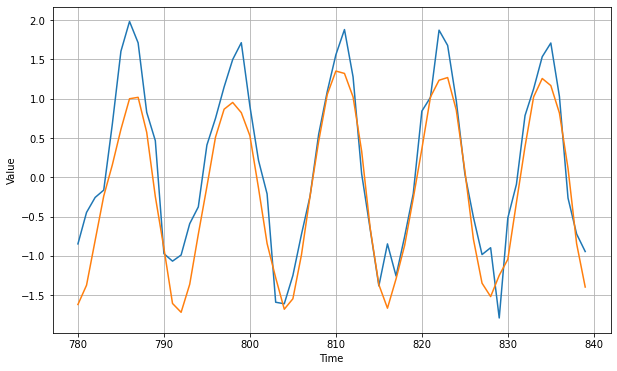

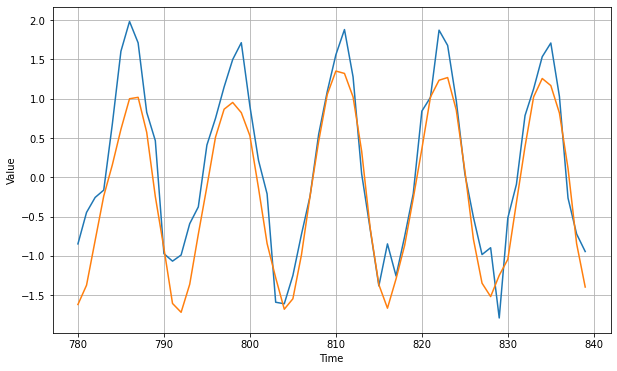

In [13]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()


In [14]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.3825486


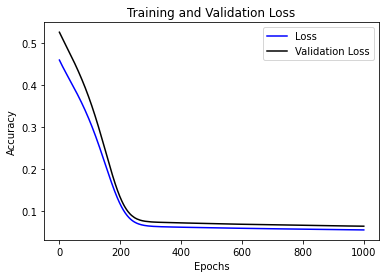

<Figure size 432x288 with 0 Axes>

In [15]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
